In [ ]:
# Install Dependencies
!pip install gluonts
!pip install mxnet
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

df = pd.read_csv('/content/drive/Shareddrives/Neural Networks Final Project/ignition_data_ts.csv',index_col=0,parse_dates=True,header=0) # Read CSV
df.head() #2190 rows

,n_fires,log_n_fires
REP_DATE,,
1979-12-30,5,1.791759
1980-01-06,0,0.000000
1980-01-13,1,0.693147
1980-01-20,1,0.693147
1980-01-27,3,1.386294


In [ ]:
# Declare constant group column 
from gluonts.dataset.pandas import PandasDataset

# The code below works so the next step is to add a train test split

# Take the first 1750 rows for training (roughly 75%)
train_df = df[:1750]

# Take the rest of the rows for testing
test_df = df[1750:]

# Create Training and Test Sets using the PandasDataset class
train_ds = PandasDataset(train_df, freq='1W', target='log_n_fires')
test_ds = PandasDataset(test_df, freq='1W', target='log_n_fires')

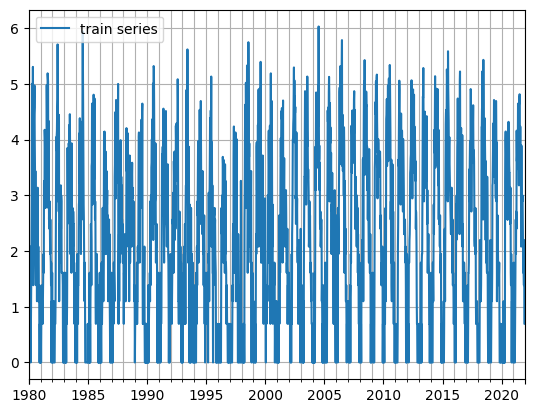

In [ ]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

entry = next(iter(train_ds))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [ ]:
from gluonts.mx import Trainer
from gluonts.torch.model.tft import TemporalFusionTransformerEstimator

estimator = TemporalFusionTransformerEstimator(
    freq="1W",
    prediction_length=10, # Predicting the next ten weeks
    context_length=6, # Higher Context Length
    #trainer=Trainer(ctx="cpu", epochs=50, learning_rate=1e-3, num_batches_per_epoch=20, weight_decay = 1e-4, hybridize = False),
    hidden_dim=32,
    num_heads=4,
    dropout_rate=0.1,
)

# This works but it is clear that we need to use GPUs, I need to understand how the new trainer function works too
predictor = estimator.train(train_ds)


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                           | Params | In sizes                                                                

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 8.49265 (best 8.49265), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 6.77245 (best 6.77245), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 6.27901 (best 6.27901), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 6.00565 (best 6.00565), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 300

In [ ]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=10,  # number of sample paths we want for evaluation
)

type(forecast_it)
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
import numpy as np
# first entry of the time series list
ts_entry = tss[0]

# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

# first 5 values
dataset_test_entry["target"][:5]

array([3.4657359 , 3.68887945, 3.13549422, 4.15888308, 3.71357207])

In [ ]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [ ]:
forecast_entry

QuantileForecast(array([[ 2.1388774 ,  2.0918903 ,  2.0493674 ,  1.7639121 ,  1.5489508 ,
         1.1920644 ,  0.935773  ,  0.3324201 , -0.24733686, -0.40885067],
       [ 2.458964  ,  2.418429  ,  2.3651156 ,  2.0930884 ,  1.9642167 ,
         1.640471  ,  1.3587162 ,  0.86969733,  0.38768268,  0.2124536 ],
       [ 2.6247382 ,  2.625223  ,  2.5979187 ,  2.3305042 ,  2.2256699 ,
         1.9317784 ,  1.6135685 ,  1.2223865 ,  0.7570622 ,  0.5803189 ],
       [ 2.7838693 ,  2.8111246 ,  2.7762306 ,  2.5192459 ,  2.4479215 ,
         2.1739757 ,  1.8635253 ,  1.4752749 ,  1.0275315 ,  0.835299  ],
       [ 2.888286  ,  2.89162   ,  2.8439305 ,  2.6606083 ,  2.5750997 ,
         2.328908  ,  2.0360641 ,  1.7069854 ,  1.2637595 ,  1.0657301 ],
       [ 3.0015423 ,  3.008805  ,  2.9790936 ,  2.7667503 ,  2.6884243 ,
         2.433551  ,  2.1070557 ,  1.861095  ,  1.4183909 ,  1.2234029 ],
       [ 3.1881878 ,  3.1761556 ,  3.1315815 ,  2.926929  ,  2.84762   ,
         2.5909345 ,  2.2866

In [ ]:
import matplotlib.pyplot as plt
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
         f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(30, 15))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot()
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()



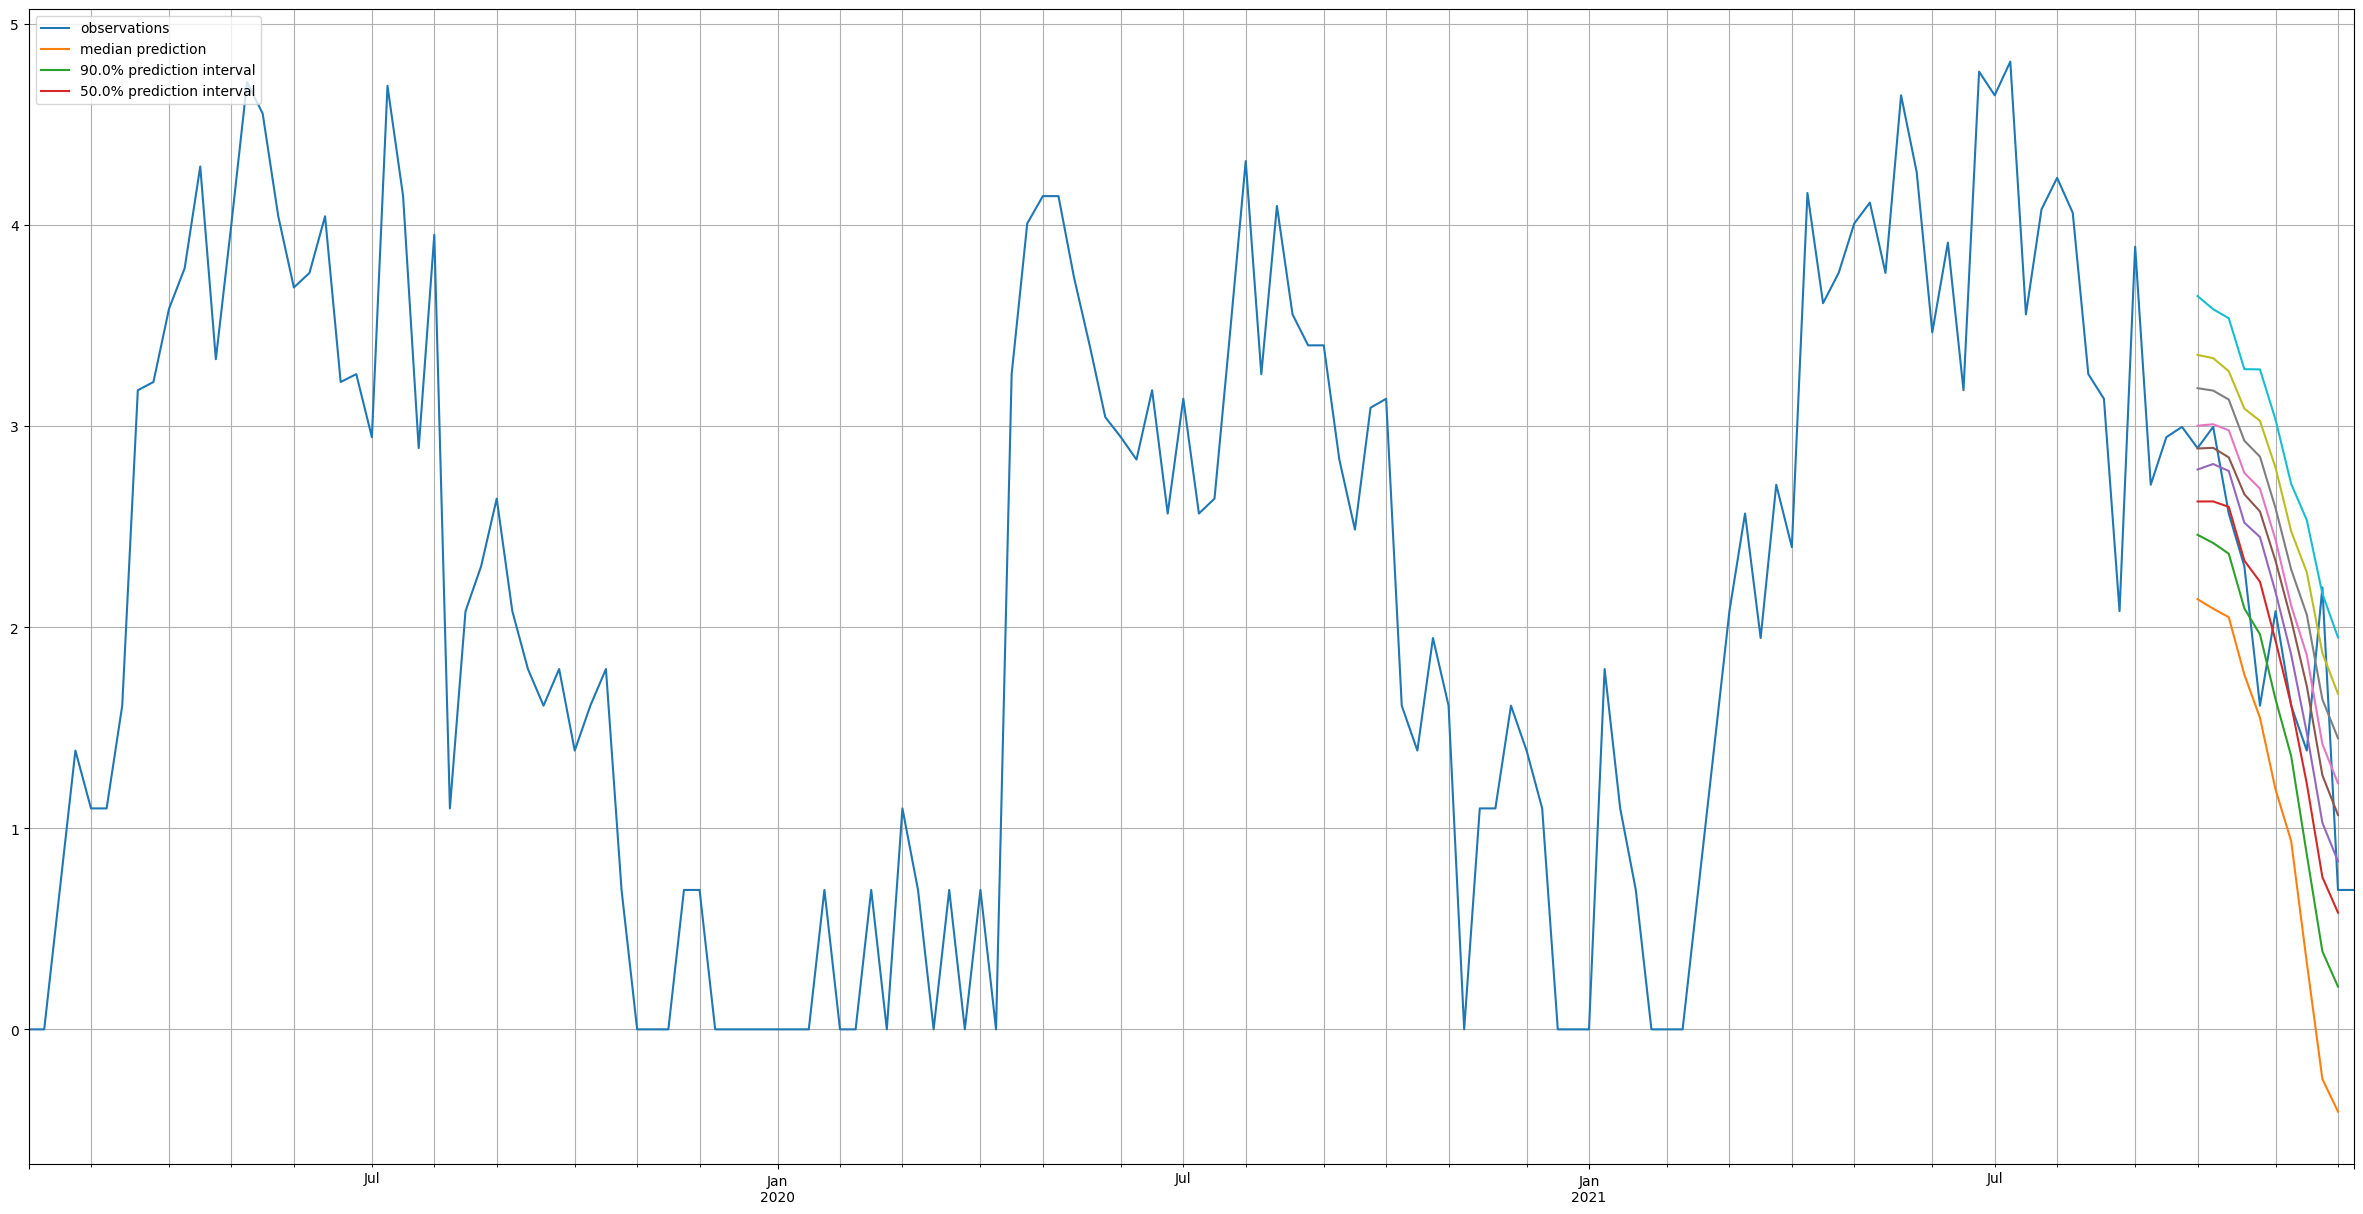

In [ ]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [ ]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 1it [00:00, 21.40it/s]


In [ ]:
import json
print(json.dumps(agg_metrics, indent=4))



{
    "MSE": 0.3406538218428947,
    "abs_error": 5.324964948655467,
    "abs_target_sum": 18.131397390133618,
    "abs_target_mean": 1.8131397390133617,
    "seasonal_error": 0.5973869519845737,
    "MASE": 0.8913761726742523,
    "MAPE": 0.37894215218090344,
    "sMAPE": 0.30750126443175996,
    "MSIS": 5.388095291929475,
    "QuantileLoss[0.1]": 1.6558142118590855,
    "Coverage[0.1]": 0.1,
    "QuantileLoss[0.5]": 5.324964948655467,
    "Coverage[0.5]": 0.8,
    "QuantileLoss[0.9]": 2.3174752665029996,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.5836555678162376,
    "NRMSE": 0.3219032462075095,
    "ND": 0.2936875097974026,
    "wQuantileLoss[0.1]": 0.09132303353298701,
    "wQuantileLoss[0.5]": 0.2936875097974026,
    "wQuantileLoss[0.9]": 0.12781559063749146,
    "mean_absolute_QuantileLoss": 3.099418142339184,
    "mean_wQuantileLoss": 0.17094204465596038,
    "MAE_Coverage": 0.5,
    "OWA": NaN
}


In [ ]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()



Note: In running these section code was used from the GluonTS official tutorial documentation. This includes the plotting function and the validation metrics. For more info on these fantastic tutorials please refer to the website.

Reference:

Amazon. (n.d.). Quick start tutorial. Quick Start Tutorial - GluonTS documentation. Retrieved December 13, 2022, from https://ts.gluon.ai/stable/tutorials/forecasting/quick_start_tutorial.html 